In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import torch
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModelForSequenceClassification
from torch.nn import CrossEntropyLoss
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_recall_fscore_support
import mlflow
import mlflow.transformers

In [22]:
df = pd.read_csv("film_sentiment.csv")
df["Sentence"] = df["Sentence"].str.replace(r"<[^>]+>", " ", regex=True)
df.head(10)

,Emotion,Sentence
0,positive,One of the other reviewers has mentioned that ...
1,positive,A wonderful little production. The filming t...
2,positive,I thought this was a wonderful way to spend ti...
3,negative,Basically there's a family where a little boy ...
4,positive,"Petter Mattei's ""Love in the Time of Money"" is..."
5,positive,"Probably my all-time favorite movie, a story o..."
6,positive,I sure would like to see a resurrection of a u...
7,negative,"This show was an amazing, fresh & innovative i..."
8,negative,Encouraged by the positive comments about this...
9,positive,If you like original gut wrenching laughter yo...


## EDA

In [24]:
# Shows number of nans
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   50000 non-null  object
 1   Sentence  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [25]:
# Find duplicated sentence
dup_sentences = df[df.duplicated(subset=["Sentence"], keep=False)]
dup_sentences.sort_values("Sentence").head(20)

# Drop duplicated sentence
df = df.drop_duplicates(subset=["Sentence"]).reset_index(drop=True)

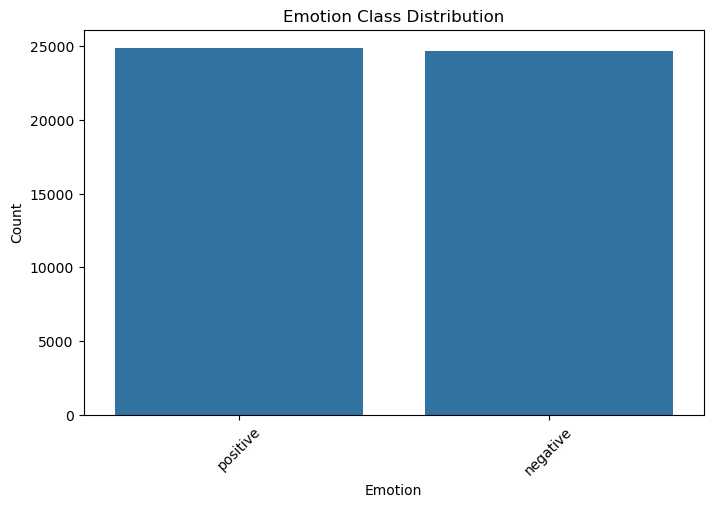

In [26]:
# Label apperance
emotion_counts = df['Emotion'].value_counts()
emotion_counts
plt.figure(figsize=(8,5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.xticks(rotation=45)
plt.title("Emotion Class Distribution")
plt.ylabel("Count")
plt.show()

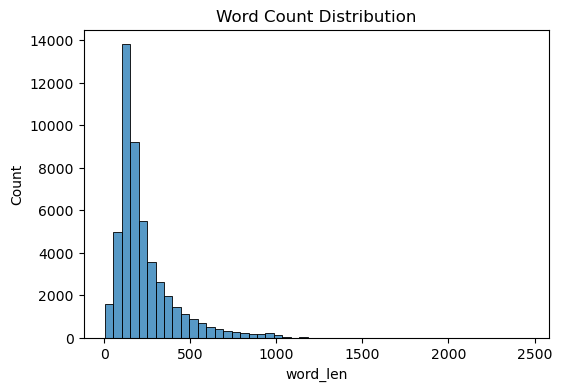

In [27]:
# Word count distribution
df_word = df.copy()
df_word['char_len'] = df_word['Sentence'].str.len()
df_word['word_len'] = df_word['Sentence'].str.split().apply(len)
df_word[['char_len', 'word_len']].describe()
plt.figure(figsize=(6,4))
sns.histplot(df_word['word_len'], bins=50)
plt.title("Word Count Distribution")
plt.show()

# Using MAX_LENGTH=512.

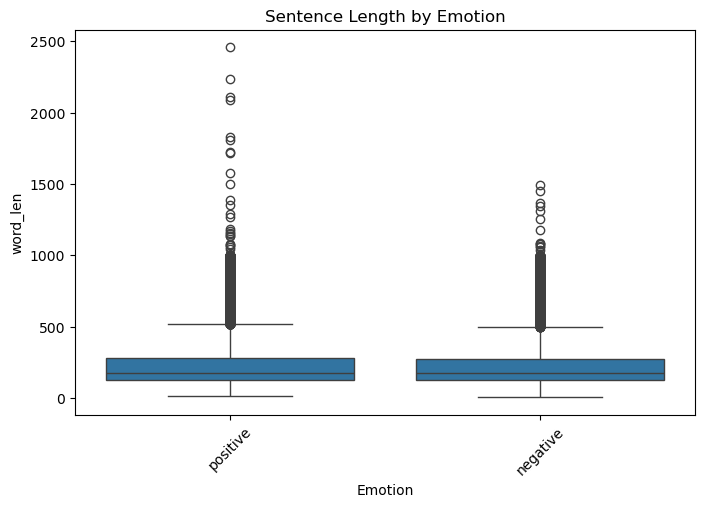

In [28]:
# Sentence length by emotion
plt.figure(figsize=(8,5))
sns.boxplot(x='Emotion', y='word_len', data=df_word)
plt.xticks(rotation=45)
plt.title("Sentence Length by Emotion")
plt.show()

# The model can't assign label based on length.

## Data Processing

In [30]:
RANDOM_STATE = 42

# 1. Split out test first (15%)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df["Emotion"],
    random_state=RANDOM_STATE
)

# 2. Split train/val from remaining
val_ratio_of_trainval = 0.15 / 0.85

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_ratio_of_trainval,
    stratify=train_val_df["Emotion"],
    random_state=RANDOM_STATE
)

print("Sizes:", len(train_df), len(val_df), len(test_df))
print("Ratios:", len(train_df)/len(df), len(val_df)/len(df), len(test_df)/len(df))

Sizes: 34706 7438 7438
Ratios: 0.6999717639465936 0.15001411802670325 0.15001411802670325


In [31]:
def show_dist(name, data):
    dist = data["Emotion"].value_counts(normalize=True).mul(100).round(2)
    print(f"\n{name} distribution (%)")
    print(dist)

show_dist("FULL", df)
show_dist("TRAIN", train_df)
show_dist("VAL", val_df)
show_dist("TEST", test_df)

# Train/Val/Test set still keeps the distribution like the full dataset.


FULL distribution (%)
Emotion
positive    50.19
negative    49.81
Name: proportion, dtype: float64

TRAIN distribution (%)
Emotion
positive    50.19
negative    49.81
Name: proportion, dtype: float64

VAL distribution (%)
Emotion
positive    50.19
negative    49.81
Name: proportion, dtype: float64

TEST distribution (%)
Emotion
positive    50.19
negative    49.81
Name: proportion, dtype: float64


In [32]:
train_df["text"] = train_df["Sentence"]
val_df["text"] = val_df["Sentence"]
test_df["text"] = test_df["Sentence"]

In [33]:
# Label encoding

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["Emotion"])
val_df["label"] = le.transform(val_df["Emotion"])
test_df["label"] = le.transform(test_df["Emotion"])

num_labels = len(le.classes_)

In [34]:
# Tokenizer
MODEL_NAME = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LENGTH = 512

In [35]:
# Dataset wrapper
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [36]:
# Handle class imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

## Modeling

In [38]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    use_safetensors=True,
    ignore_mismatched_sizes=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Loss function with class weight
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

In [40]:
# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"macro_f1": macro_f1}

In [41]:
training_args = TrainingArguments(
    output_dir="./outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1"
)

In [42]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=SentimentDataset(train_df["text"].tolist(), train_df["label"].tolist()),
    eval_dataset=SentimentDataset(val_df["text"].tolist(), val_df["label"].tolist()),
    compute_metrics=compute_metrics,
)

## Export

In [63]:
# Keep track of the new model
with mlflow.start_run() as run:
    trainer.train()

    test_metrics = trainer.evaluate(
        SentimentDataset(
            test_df["text"].tolist(),
            test_df["label"].tolist()
        )
    )

    mlflow.log_params({
        "model_name": trainer.model.config._name_or_path,
        "num_labels": trainer.model.config.num_labels
    })

    mlflow.log_metrics({
        "eval_loss": test_metrics["eval_loss"],
        "eval_macro_f1": test_metrics["eval_macro_f1"]
    })

    mlflow.transformers.log_model(
        transformers_model={
            "model": trainer.model,
            "tokenizer": tokenizer
        },
        task="text-classification",
        artifact_path="model"
    )

    run_id = run.info.run_id

mlflow.register_model(
    model_uri=f"runs:/{run_id}/model",
    name="film-sentiment-transformer"
)

2026/01/21 15:26:38 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/21 15:26:38 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/21 15:26:38 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/21 15:26:38 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/21 15:26:38 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/21 15:26:38 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/21 15:26:38 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/21 15:26:39 INFO mlflow.store.db.utils: Updating database tables
2026/01/21 15:26:39 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/21 15:26:39 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/21 15:26:39 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/21 15:2

Epoch,Training Loss,Validation Loss,Macro F1
1,0.656200,0.636991,0.670831
2,0.596700,0.569339,0.727439
3,0.553100,0.531860,0.750827
4,0.528000,0.519862,0.755841


2026/01/21 15:30:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Device set to use cuda:0
2026/01/21 15:30:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/21 15:30:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/21 15:30:37 WARNING mlflow.utils.environment: On Windows, timeout is not supported for model r

<ModelVersion: aliases=[], creation_timestamp=1768984253693, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1768984253693, metrics=None, model_id=None, name='film-sentiment-transformer', params=None, run_id='c615634136ef42b797622854d3a7e149', run_link=None, source='models:/m-a5f8c1b1dee341efa3b7e4255842e0fc', status='READY', status_message=None, tags={}, user_id=None, version=1>